In [1]:
from dsc80_utils import *

# Lecture 12 – Text Features

## DSC 80, Winter 2025

### Announcements 📣

- Lab 6 due **tomorrow**.
- Project 3 due **Friday**.
- We're working on Midterm grades now and they should be out shortly
- Also, please complete the [Mid-Quarter Survey](https://docs.google.com/forms/d/e/1FAIpQLSfR0DyU8BnvZq7N3847ddwdwyKoaJICEvkNbo7ncr-U_Tt1Lg/viewform?usp=sf_link). If 80% of class fills it out, everyone gets +1% EC for the midterm.

### Agenda 📆

- Text features.
- Bag of words.
- Cosine similarity.
- TF-IDF.
    - Example: State of the Union addresses 🎤.

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `weird_re`
</div>

`^\w{2,5}.\d*\/[^A-Z5]{1,}`

Select all strings below that contain any match with the regular expression above.

- `"billy4/Za"`
- `"billy4/za"`
- `"DAI_s2154/pacific"`
- `"daisy/ZZZZZ"`
- `"bi_/_lly98"`
- `"!@__!14/atlantic"`
    
</div>

(This problem was from Sp22 Final question 7.2.)

## Text features

<center><img src='imgs/ds-lifecycle.svg' width=60%></center>

### Review: Regression and features

- In DSC 40A, our running example was to use **regression** to predict a data scientist's salary, given their GPA, years of experience, and years of education.

- After minimizing empirical risk to determine optimal parameters, $w_0^*, \dots, w_3^*$, we made predictions using:

$$\text{predicted salary} = w_0^* + w_1^* \cdot \text{GPA} + w_2^* \cdot \text{experience} + w_3^* \cdot \text{education}$$

- GPA, years of experience, and years of education are **features** – they represent a data scientist as a vector of _numbers_.
    - e.g. Your feature vector may be [3.5, 1, 7].

- **This approach requires features to be numeric.**

### Moving forward

Suppose we'd like to predict the **sentiment** of a piece of text from 1 to 10.
- 10: Very positive (happy).
- 1: Very negative (sad, angry).

Example:
- Input: "DSC 80 is a pretty good class."
- Output: 7.

- We can frame this as a regression problem, but we can't directly use what we learned in 40A, because here our inputs are **text**, not **numbers**.

### Text features

- **Big question: How do we represent a text document as a feature vector of numbers?**

- If we can do this, we can:
    - use a text document as input in a regression or classification model (in a few lectures).
    - **quantify** the similarity of two text documents (today).

### Example: San Diego employee salaries

- [Transparent California](https://transparentcalifornia.com/salaries/san-diego/) publishes the salaries of all City of San Diego employees.
- Let's look at the 2022 data.

In [2]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2022.csv')
salaries['Employee Name'] = salaries['Employee Name'].str.split().str[0] + ' Xxxx'

In [3]:
salaries.head()

,Employee Name,Job Title,Base Pay,Overtime Pay,...,Year,Notes,Agency,Status
0,Mara Xxxx,City Attorney,227441.53,0.00,...,2022,NaN,San Diego,FT
1,Todd Xxxx,Mayor,227441.53,0.00,...,2022,NaN,San Diego,FT
2,Terence Xxxx,Assistant Police Chief,227224.32,0.00,...,2022,NaN,San Diego,FT
3,Esmeralda Xxxx,Police Sergeant,124604.40,162506.54,...,2022,NaN,San Diego,FT
4,Marcelle Xxxx,Assistant Retirement Administrator,279868.04,0.00,...,2022,NaN,San Diego,FT


### Aside on privacy and ethics

- Even though the data we downloaded is publicly available, employee names still correspond to real people.

- Be careful when dealing with PII (personably identifiable information).
    - Only work with the data that is needed for your analysis.
    - Even when data is public, people have a reasonable right to privacy.

- Remember to think about the impacts of your work **outside** of your Jupyter Notebook.

### Goal: Quantifying similarity

- Our goal is to describe, numerically, how **similar** two job titles are.

- For instance, our similarity metric should tell us that `'Deputy Fire Chief'` and `'Fire Battalion Chief'` are more similar than `'Deputy Fire Chief'` and `'City Attorney'`.

- **Idea**: Two job titles are similar if they contain shared words, regardless of order. So, to measure the similarity between two job titles, we could **count the number of words they share in common**.

- Before we do this, we need to be confident that the job titles are clean and consistent – let's explore.

### Exploring job titles

In [4]:
jobtitles = salaries['Job Title']
jobtitles.head()

0                         City Attorney
1                                 Mayor
2                Assistant Police Chief
3                       Police Sergeant
4    Assistant Retirement Administrator
Name: Job Title, dtype: object

How many employees are in the dataset? How many **unique** job titles are there?

In [5]:
jobtitles.shape[0], jobtitles.nunique()

(12831, 611)

What are the most common job titles?

In [6]:
jobtitles.value_counts().iloc[:100]

Job Title
Police Officer Ii               1082
Police Sergeant                  311
Fire Fighter Ii                  306
                                ... 
Public Works Supervisor           29
Project Assistant                 29
Associate Engineer - Traffic      29
Name: count, Length: 100, dtype: int64

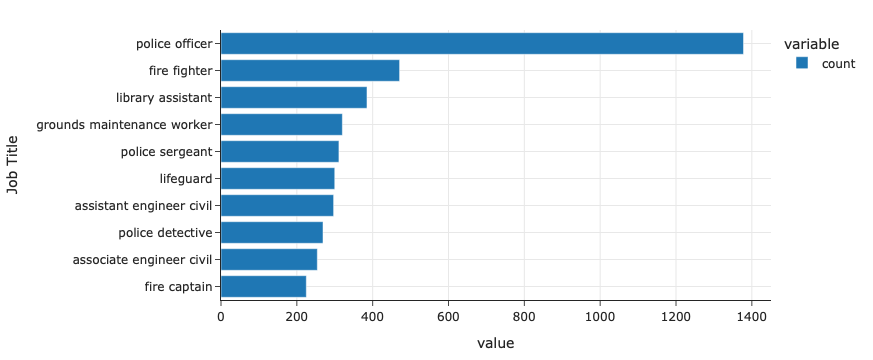

In [79]:
jobtitles.value_counts().iloc[:10].sort_values().plot(kind='barh')

Are there any missing job titles?

In [8]:
jobtitles.isna().sum()

np.int64(0)

Fortunately, no.

### Canonicalization

Remember, our goal is ultimately to count the number of shared words between job titles. But before we start counting the number of shared words, we need to consider the following:

- Some job titles may have **punctuation**, like `'-'` and `'&'`, which may count as words when they shouldn't.
    - `'Assistant - Manager'` and `'Assistant Manager'` should count as the same job title.


- Some job titles may have **"glue" words**, like `'to'` and `'the'`, which (we can argue) also shouldn't count as words.
    - `'Assistant To The Manager'` and `'Assistant Manager'` should count as the same job title.

- If we just want to focus on the titles themselves, then perhaps **roman numerals** should be removed: that is, `'Police Officer Ii'` and `'Police Officer I'` should count as the same job title. 

Let's address the above issues. The process of converting job titles so that they are always represented the same way is called **canonicalization**.

### Punctuation

Are there job titles with unnecessary punctuation that we can remove? 

- To find out, we can write a regular expression that looks for characters other than letters, numbers, and spaces.

- We can use regular expressions with the `.str` methods we learned earlier in the quarter just by using `regex=True`.

In [9]:
# Uses character class negation.
jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True).sum()

np.int64(922)

In [10]:
jobtitles[jobtitles.str.contains(r'[^A-Za-z0-9 ]', regex=True)].head()

137          Park & Recreation Director
248     Associate Engineer - Mechanical
734     Associate Engineer - Electrical
882        Associate Engineer - Traffic
1045         Associate Engineer - Civil
Name: Job Title, dtype: object

It seems like we should replace these pieces of punctuation with a single space.

### "Glue" words

Are there job titles with "glue" words in the middle, such as `'Assistant to the Manager'`?

To figure out if any titles contain the word `'to'`, we **can't** just do the following, because it will evaluate to `True` for job titles that have `'to'` anywhere in them, even if not as a standalone word.

In [11]:
# Why are we converting to lowercase?
jobtitles.str.lower().str.contains('to').sum()

np.int64(1577)

In [12]:
jobtitles[jobtitles.str.lower().str.contains('to')]

0                             City Attorney
4        Assistant Retirement Administrator
8                  Retirement Administrator
                        ...                
12778                        Test Monitor I
12812                           Custodian I
12826              Word Processing Operator
Name: Job Title, Length: 1577, dtype: object

Instead, we need to look for `'to'` separated by word boundaries.

In [13]:
jobtitles.str.lower().str.contains(r'\bto\b', regex=True).sum()

np.int64(10)

In [14]:
jobtitles[jobtitles.str.lower().str.contains(r'\bto\b', regex=True)]

1638              Assistant To The Chief Operating Officer
2183                  Principal Assistant To City Attorney
2238                             Assistant To The Director
                               ...                        
6594     Confidential Secretary To Chief Operating Officer
6832                       Confidential Secretary To Mayor
11028                      Confidential Secretary To Mayor
Name: Job Title, Length: 10, dtype: object

We can look for other filler words too, like `'the'` and `'for'`.

In [15]:
jobtitles[jobtitles.str.lower().str.contains(r'\bthe\b', regex=True)]

1638    Assistant To The Chief Operating Officer
2238                   Assistant To The Director
5609                   Assistant To The Director
6544                   Assistant To The Director
Name: Job Title, dtype: object

In [16]:
jobtitles[jobtitles.str.lower().str.contains(r'\bfor\b', regex=True)]

3449     Assistant For Community Outreach
6889     Assistant For Community Outreach
10810    Assistant For Community Outreach
Name: Job Title, dtype: object

We should probably remove these "glue" words.

### Roman numerals (e.g. "Ii")

Lastly, let's try and identify job titles that have roman numerals at the end, like `'i'` (1), `'ii'` (2), `'iii'` (3), or `'iv'` (4). As before, we'll convert to lowercase first.

In [17]:
jobtitles[jobtitles.str.lower().str.contains(r'\bi+v?\b', regex=True)]

5                   Police Officer Ii
10                  Police Officer Ii
48       Fire Prevention Inspector Ii
                     ...             
12822           Clerical Assistant Ii
12828               Police Officer Ii
12830                Police Officer I
Name: Job Title, Length: 6087, dtype: object

Let's get rid of those numbers, too.

### Fixing punctuation and removing "glue" words and roman numerals

Let's put the preceeding three steps together and canonicalize job titles by:
- converting to lowercase,
- removing each occurrence of `'to'`, `'the'`, and `'for'`,
- replacing each non-letter/digit/space character with a space,
- replacing each sequence of roman numerals – either `'i'`, `'ii'`, `'iii'`, or `'iv'` at the end with nothing, and
- replacing each sequence of multiple spaces with a single space.

In [18]:
jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto\b|\bthe\b|\bfor\b', '', regex=True)
    .str.replace(r'[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(r'\bi+v?\b', '', regex=True)
    .str.replace(r' +', ' ', regex=True)               # ' +' matches 1 or more occurrences of a space.
    .str.strip()                                       # Removes leading/trailing spaces if present.
)

In [19]:
jobtitles.sample(5)

7255              finance analyst
10760           library assistant
4350               police officer
3902     senior personnel analyst
6170                  electrician
Name: Job Title, dtype: object

In [20]:
(jobtitles == 'police officer').sum()

np.int64(1378)

## Bag of words 💰

### Text similarity

Recall, our idea is to measure the similarity of two job titles by counting the number of shared words between the job titles. How do we actually do that, for all of the job titles we have?

### A counts matrix

Let's create a "counts" matrix, such that:
- there is 1 row per job title,
- there is 1 column per **unique** word that is used in job titles, and
- the value in row `title` and column `word` is the number of occurrences of `word` in `title`.

Such a matrix might look like:

| | senior | lecturer | teaching | professor | assistant | associate |
| --- | --- | --- | --- | --- | --- | --- |
| **senior lecturer** | 1 | 1 | 0 | 0 | 0 | 0 |
| **assistant teaching professor** | 0 | 0 | 1 | 1 | 1 | 0 | 
| **associate professor** | 0 | 0 | 0 | 1 | 0 | 1 |
| **senior assistant to the assistant professor** | 1 | 0 | 0 | 1 | 2 | 0 |

Then, we can make statements like: "assistant teaching professor" is more similar to "associate professor" than to "senior lecturer".

### Creating a counts matrix

First, we need to determine all words that are used across all job titles.

In [23]:
jobtitles.str.split()

0                  [city, attorney]
1                           [mayor]
2        [assistant, police, chief]
                    ...            
12828             [police, officer]
12829          [police, dispatcher]
12830             [police, officer]
Name: Job Title, Length: 12831, dtype: object

In [24]:
# The .explode method concats the lists together.
all_words = jobtitles.str.split().explode()
all_words

0              city
0          attorney
1             mayor
            ...    
12829    dispatcher
12830        police
12830       officer
Name: Job Title, Length: 30057, dtype: object

Next, to determine the columns of our matrix, we need to find a list of all **unique** words used in titles. We can do this with `np.unique`, but `value_counts` shows us the distribution, which is interesting.

In [25]:
unique_words = all_words.value_counts()
unique_words

Job Title
police       2299
officer      1608
assistant    1267
             ... 
relations       1
dna             1
gardener        1
Name: count, Length: 330, dtype: int64

Note that in `unique_words.index`, job titles are sorted by number of occurrences!

For each of the 330 unique words that are used in job titles, we can count the number of occurrences of the word in each job title.
- `'deputy fire chief'` contains the word `'deputy'` once, the word `'fire'` once, and the word `'chief'` once.
- `'assistant managers assistant'` contains the word `'assistant'` twice and the word `'managers'` once.

In [26]:
# Created using a dictionary to avoid a "DataFrame is highly fragmented" warning.
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(jobtitles)

In [27]:
counts_df.head()

,police,officer,assistant,fire,...,emergency,relations,dna,gardener
Job Title,,,,,,,,,
city attorney,0,0,0,0,...,0,0,0,0
mayor,0,0,0,0,...,0,0,0,0
assistant police chief,1,0,1,0,...,0,0,0,0
police sergeant,1,0,0,0,...,0,0,0,0
assistant retirement administrator,0,0,1,0,...,0,0,0,0


In [28]:
counts_df.shape

(12831, 330)

`counts_df` has one row for all 12831 employees, and one column for each unique word that is used in a job title.

Its third row, for example, tells us that the third job title contains `'police'` once and `'assistant'` once.

### Bag of words

- The **bag of words** model represents texts (e.g. job titles, sentences, documents) as **vectors of word counts**.
    - The "counts" matrices we have worked with so far were created using the bag of words model.
    - The bag of words model defines a **vector space** in $\mathbb{R}^{\text{number of unique words}}$.
    - In the matrix on the previous slide, each **row** was a vector corresponding to a specific job title.
- It is called "bag of words" because it doesn't consider **order**.

<center><img src='imgs/bag-of-words.jpeg' width=45%></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

## Cosine similarity

### Question: What job titles are most similar to `'deputy fire chief'`?

- Remember, our idea was to count the number of shared words between two job titles.

- We now have access to `counts_df`, which contains a row vector for each job title.

- How can we use it to count the number of shared words between two job titles?

### Counting shared words

To start, let's compare the row vectors for `'deputy fire chief'` and `'fire battalion chief'`.

In [29]:
dfc = counts_df.loc['deputy fire chief'].iloc[0]
dfc

police       0
officer      0
assistant    0
            ..
relations    0
dna          0
gardener     0
Name: deputy fire chief, Length: 330, dtype: int64

In [30]:
fbc = counts_df.loc['fire battalion chief'].iloc[0]
fbc

police       0
officer      0
assistant    0
            ..
relations    0
dna          0
gardener     0
Name: fire battalion chief, Length: 330, dtype: int64

We can stack these two vectors horizontally.

In [31]:
pair_counts = (
    pd.concat([dfc, fbc], axis=1)
    .sort_values(by=['deputy fire chief', 'fire battalion chief'], ascending=False)
    .head(10)
    .T
)

pair_counts

,fire,chief,deputy,battalion,...,assistant,engineer,civil,technician
deputy fire chief,1,1,1,0,...,0,0,0,0
fire battalion chief,1,1,0,1,...,0,0,0,0


`'deputy fire chief'` and `'fire battalion chief'` have 2 shared words in common. One way to arrive at this result mathematically is by taking their **dot product**:

In [32]:
np.dot(pair_counts.iloc[0], pair_counts.iloc[1])

np.int64(2)

### Recall: The dot product

- Recall, if $\vec{a} = \begin{bmatrix} a_1 & a_2 & ... & a_n \end{bmatrix}^T$ and $\vec{b} = \begin{bmatrix} b_1 & b_2 & ... & b_n \end{bmatrix}^T$ are two vectors, then their **dot product** $\vec{a} \cdot \vec{b}$ is defined as:

$$\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + ... + a_nb_n$$

- The dot product also has a **geometric** interpretation. If $|\vec{a}|$ and $|\vec{b}|$ are the $L_2$ norms (lengths) of $\vec{a}$ and $\vec{b}$, and $\theta$ is the angle between $\vec{a}$ and $\vec{b}$, then:

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cos \theta$$

<center><img src='imgs/dot-prod.png' width=20%>(<a href="https://byjus.com/physics/scalar-and-vector-products/">source</a>)</center>

- $\cos \theta$ is equal to its maximum value (1) when $\theta = 0$, i.e. when $\vec{a}$ and $\vec{b}$ point in the same direction. 

### Cosine similarity and bag of words

To measure the similarity between two word vectors, instead of just counting the number of shared words, we should compute their **normalized** dot product, also known as their **cosine similarity**.

$$\cos \theta = \boxed{\frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}}$$

- If all elements in $\vec{a}$ and $\vec{b}$ are non-negative, then $\cos \theta$ ranges from 0 to 1.

- 🚨 **Key idea: The larger $\cos \theta$ is, the more similar the two vectors are!**

- **It is important to normalize by the lengths of the vectors**, otherwise texts with more words will have artificially high similarities with other texts.

### Normalizing

$$\cos \theta = \boxed{\frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}}$$

- Why can't we just use the dot product – that is, why must we divide by $|\vec{a}| | \vec{b}|$?

- Consider the following example:

| | big | data | science | 
| --- | --- | --- | --- |
| **big big big big data** | 4 | 1 | 0 |
| **big data science** | 1 | 1 | 1 |
| **science big data** | 1 | 1 | 1 |

| Pair | Dot Product | Cosine Similarity |
| --- | --- | --- |
| **big data science** and **big big big big data** | 5 | 0.7001 |
| **big data science** and **science big data** | 3 | 1 |

- `'big big big big data'` has a large dot product with `'big data science'` just because it has the word `'big'` four times. But intuitively, `'big data science'` and `'science big data'` should be as similar as possible, since they're permutations of the same sentence.

- **So, make sure to compute the cosine similarity – don't just use the dot product!**

**Note**: Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
  $$\text{dist}(\vec{a}, \vec{b}) = 1 - \cos \theta$$
  
If $\text{dist}(\vec{a}, \vec{b})$ is small, the two word vectors are similar.

### A recipe for computing similarities

Given a set of documents, to find the **most similar** text to one _document_ $d$ in particular:

- Use the bag of words model to create a counts matrix, in which:
    - there is 1 row per document,
    - there is 1 column per **unique** word that is used across documents, and
    - the value in row `doc` and column `word` is the number of occurrences of `word` in `doc`.

- Compute the cosine similarity between $d$'s row vector and all other documents' row vectors.

- The other document with the greatest cosine similarity is the most similar, under the bag of words model.

### Example: Global warming 🌎

Consider the following three documents.

In [33]:
sentences = pd.Series([
    'I really really want global peace',
    'I must enjoy global warming',
    'We must solve climate change'
])

sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

Let's represent each document using the bag of words model.

In [34]:
unique_words = sentences.str.split().explode().value_counts()
unique_words

I          2
really     2
global     2
          ..
solve      1
climate    1
change     1
Name: count, Length: 12, dtype: int64

In [35]:
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = sentences.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(sentences)

In [36]:
counts_df

,I,really,global,must,...,We,solve,climate,change
I really really want global peace,1,2,1,0,...,0,0,0,0
I must enjoy global warming,1,0,1,1,...,0,0,0,0
We must solve climate change,0,0,0,1,...,1,1,1,1


Let's now find the cosine similarity between each document.

In [37]:
counts_df

,I,really,global,must,...,We,solve,climate,change
I really really want global peace,1,2,1,0,...,0,0,0,0
I must enjoy global warming,1,0,1,1,...,0,0,0,0
We must solve climate change,0,0,0,1,...,1,1,1,1


In [38]:
def sim_pair(s1, s2):
    return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))

In [39]:
# Look at the documentation of the .corr method to see how this works!
counts_df.T.corr(sim_pair)

,I really really want global peace,I must enjoy global warming,We must solve climate change
I really really want global peace,1.00,0.32,0.0
I must enjoy global warming,0.32,1.00,0.2
We must solve climate change,0.00,0.20,1.0


**Issue**: Bag of words only encodes the **words** that each document uses, not their **meanings**.
- "I really really want global peace" and "We must solve climate change" have similar meanings, but have no shared words, and thus a low cosine similarity.
- "I really really want global peace" and "I must enjoy global warming" have very different meanings, but a relatively high cosine similarity.

### Pitfalls of the bag of words model

Remember, the key assumption underlying the bag of words model is that **two documents are similar if they share many words in common**.

- The bag of words model doesn't consider **order**.
    - The job titles `'deputy fire chief'` and `'chief fire deputy'` are treated as the same.

- The bag of words model doesn't consider the **meaning** of words.
    - `'I love data science'` and `'I hate data science'` share 75% of their words, but have very different meanings.

- The bag of words model treats all words as being equally important.
    - `'deputy'` and `'fire'` have the same importance, even though `'fire'` is probably more important in describing someone's job title.
    - <span style="color:red"><b>Let's address this point.</b></span>

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `bow`
</div>

From the Fa23 final:
        
Consider the following corpus:

```
Document number Content
1               yesterday rainy today sunny
2               yesterday sunny today sunny
3               today rainy yesterday today
4               yesterday yesterday today today
```
        
1. Using a bag-of-words representation, which two documents have the largest dot product?
2. Using a bag-of-words representation, what is the cosine similarity between documents 2 and 3?

## TF-IDF

### The importance of words

**Issue**: The bag of words model doesn't know which words are "important" in a document. Consider the following document:

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

How do we determine which words are important?
- The most common words ("the", "has") often **don't** have much meaning!
- The very rare words are also less important!

**Goal**: Find a way of quantifying the importance of a word in a document by **balancing the above two factors**, i.e. find the word that **best summarizes** a document.

### Term frequency

- The **term frequency** of a word (term) $t$ in a document $d$, denoted $\text{tf}(t, d)$ is the proportion of words in document $d$ that are equal to $t$.

$$
\text{tf}(t, d)= \frac{\text{\# of occurrences of $t$ in $d$}}{\text{total \# of words in $d$}}
$$

- **Example**: What is the term frequency of "billy" in the following document?

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

- **Answer**: $\frac{2}{13}$.

- Intuition: Words that occur often within a document are important to the document's meaning.
    - If $\text{tf}(t, d)$ is large, then word $t$ occurs often in $d$.
    - If $\text{tf}(t, d)$ is small, then word $t$ does not occur often $d$.

- Issue: "has" also has a TF of $\frac{2}{13}$, but it seems less important than "billy".

### Inverse document frequency

- The **inverse document frequency** of a word $t$ in a set of documents $d_1, d_2, ...$ is

$$\text{idf}(t) = \log \left(\frac{\text{total \# of documents}}{\text{\# of documents in which $t$ appears}} \right)$$

- **Example**: What is the inverse document frequency of "billy" in the following three documents?
    - "my brother has a friend named **billy** who has an uncle named **billy**"
    - "my favorite artist is named jilly boel"
    - "why does he talk about someone named **billy** so often"

- **Answer**: $\log \left(\frac{3}{2}\right) \approx 0.4055$.

- Intuition: If a word appears in every document (like "the" or "has"), it is probably not a good summary of any one document.
    - If $\text{idf}(t)$ is large, then $t$ is rarely found in documents.
    - If $\text{idf}(t)$ is small, then $t$ is commonly found in documents.
    - Think of $\text{idf}(t)$ as the "rarity factor" of $t$ across documents – the larger $\text{idf}(t)$ is, the more rare $t$ is.

### Intuition

$$\text{tf}(t, d) = \frac{\text{\# of occurrences of $t$ in $d$}}{\text{total \# of words in $d$}}$$

$$\text{idf}(t) = \log \left(\frac{\text{total \# of documents}}{\text{\# of documents in which $t$ appears}} \right)$$

**Goal**: Quantify how well word $t$ **summarizes** document $d$.

- If $\text{tf}(t, d)$ is small, then $t$ doesn't occur very often in $d$, so $t$ can't be a good summary of $d$.

- If $\text{idf}(t)$ is small, then $t$ occurs often amongst all documents, and so it is not a good summary of any one document.

- If $\text{tf}(t, d)$ and $\text{idf}(t)$ are both large, then **$t$ occurs often in $d$ but rarely overall**. This makes $t$ **a good summary** of document $d$.

### Term frequency-inverse document frequency

The **term frequency-inverse document frequency (TF-IDF)** of word $t$ in document $d$ is the product:

$$
\begin{align*}
\text{tfidf}(t, d) &=
    \text{tf}(t, d) \cdot \text{idf}(t) \\\
    &= \frac{\text{\# of occurrences of $t$ in $d$}}{\text{total \# of words in $d$}}
        \cdot \log \left(\frac{\text{total \# of documents}}{\text{\# of documents in which $t$ appears}} \right)
\end{align*}
$$

- If $\text{tfidf}(t, d)$ is large, then $t$ is a good summary of $d$, because $t$ occurs often in $d$ but rarely across all documents.

- TF-IDF is a **heuristic** – it has no probabilistic justification.

- To know if $\text{tfidf}(t, d)$ is large for one particular word $t$, we need to compare it to $\text{tfidf}(t_i, d)$, for several different words $t_i$.

### Computing TF-IDF

**Question**: What is the TF-IDF of "global" in the second sentence?

In [40]:
sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

**Answer**:

In [41]:
tf = sentences.iloc[1].count('global') / len(sentences.iloc[1].split())
tf

0.2

In [42]:
idf = np.log(len(sentences) / sentences.str.contains('global').sum())
idf

np.float64(0.4054651081081644)

In [43]:
tf * idf

np.float64(0.08109302162163289)

**Question**: Is this big or small? Is "global" the **best** summary of the second sentence?

### TF-IDF of all words in all documents

On its own, the TF-IDF of a word in a document doesn't really tell us anything; we must compare it to TF-IDFs of other words in that same document.

In [44]:
sentences

0    I really really want global peace
1          I must enjoy global warming
2         We must solve climate change
dtype: object

In [45]:
unique_words = np.unique(sentences.str.split().explode())
unique_words

array(['I', 'We', 'change', 'climate', 'enjoy', 'global', 'must', 'peace',
       'really', 'solve', 'want', 'warming'], dtype=object)

In [46]:
tfidf_dict = {}

for word in unique_words:
    re_pat = fr'\b{word}\b'
    tf = sentences.str.count(re_pat) / sentences.str.split().str.len()
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf_dict[word] = tf * idf
    
tfidf = pd.DataFrame(tfidf_dict).set_index(sentences)

In [47]:
tfidf

,I,We,change,climate,...,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,...,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,...,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,...,0.00,0.22,0.00,0.00


### Interpreting TF-IDFs

In [48]:
display_df(tfidf, cols=12)

,I,We,change,climate,enjoy,global,must,peace,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,0.00,0.07,0.00,0.18,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,0.22,0.08,0.08,0.00,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,0.00,0.00,0.08,0.00,0.00,0.22,0.00,0.00


The above DataFrame tells us that:
- the TF-IDF of `'really'` in the first sentence is $\approx$ 0.37,
- the TF-IDF of `'climate'` in the second sentence is 0.

Note that there are two ways that $\text{tfidf}(t, d) = \text{tf}(t, d) \cdot \text{idf}(t)$ can be 0:
- If $t$ appears in every document, because then $\text{idf}(t) = \log (\frac{\text{\# documents}}{\text{\# documents}}) = \log(1) = 0$.
- If $t$ does not appear in document $d$, because then $\text{tf}(t, d) = \frac{0}{\text{len}(d)} = 0$.

The word that **best summarizes** a document is the word with the highest TF-IDF for that document:

In [49]:
display_df(tfidf, cols=12)

,I,We,change,climate,enjoy,global,must,peace,really,solve,want,warming
I really really want global peace,0.07,0.00,0.00,0.00,0.00,0.07,0.00,0.18,0.37,0.00,0.18,0.00
I must enjoy global warming,0.08,0.00,0.00,0.00,0.22,0.08,0.08,0.00,0.00,0.00,0.00,0.22
We must solve climate change,0.00,0.22,0.22,0.22,0.00,0.00,0.08,0.00,0.00,0.22,0.00,0.00


In [50]:
tfidf.idxmax(axis=1)

I really really want global peace    really
I must enjoy global warming           enjoy
We must solve climate change             We
dtype: object

Look closely at the rows of `tfidf` – in documents 2 and 3, the max TF-IDF is not unique!

## Example: State of the Union addresses 🎤

### State of the Union addresses

The 2024 State of the Union address was delivered on March 7th, 2024; last year's was on February 7th, 2023.

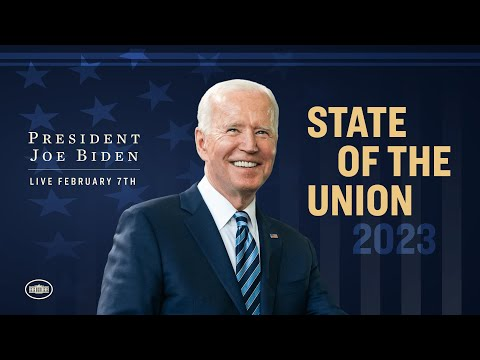

In [51]:
from IPython.display import YouTubeVideo
YouTubeVideo('gzcBTUvVp7M')

### The data

In [52]:
from pathlib import Path
sotu_txt = Path('data') / 'stateoftheunion1790-2023.txt'
sotu = sotu_txt.read_text()

In [53]:
len(sotu)

10577941

The entire **corpus** (another word for "set of documents") is over 10 million characters long... let's not display it in our notebook.

In [54]:
print(sotu[:1600])

The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2023 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Address, December 8, 1798
  John Adams, State of 

Each speech is separated by `'***'`.

In [55]:
speeches = sotu.split('\n***\n')[1:]

In [56]:
len(speeches)

233

Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [57]:
print(speeches[-1][:1000])


State of the Union Address
Joseph R. Biden Jr.  
February 7, 2023

  Mr. Speaker. Madam Vice President. Our First Lady and Second
Gentleman. Members of Congress and the Cabinet. Leaders of our
military. Mr. Chief Justice, Associate Justices, and retired Justices
of the Supreme Court. And you, my fellow Americans.
  I start tonight by congratulating the members of the 118th Congress
and the new Speaker of the House, Kevin McCarthy. Mr. Speaker, I look
forward to working together.
  I also want to congratulate the new leader of the House Democrats and
the first Black House Minority Leader in history, Hakeem Jeffries.
  Congratulations to the longest serving Senate leader in history,
Mitch McConnell.
  And congratulations to Chuck Schumer for another term as Senate
Majority Leader, this time with an even bigger majority.
  And I want to give special recognition to someone who I think will be
considered the greatest Speaker in the history of this country, Nancy
Pelosi.
  The story of Amer

Let's extract just the speech text.

In [58]:
import re
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [59]:
speeches_df = pd.DataFrame(list(map(extract_struct, speeches)))
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
...,...,...,...,...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...
231,State of the Union Address,Joseph R. Biden Jr.,"March 1, 2022",madam speaker madam vice president and our ...
232,State of the Union Address,Joseph R. Biden Jr.,"February 7, 2023",mr speaker madam vice president our firs...


### Finding the most important words in each speech

Here, a "document" is a speech. We have 233 documents.

In [60]:
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
...,...,...,...,...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...
231,State of the Union Address,Joseph R. Biden Jr.,"March 1, 2022",madam speaker madam vice president and our ...
232,State of the Union Address,Joseph R. Biden Jr.,"February 7, 2023",mr speaker madam vice president our firs...


A rough sketch of what we'll compute:

```
for each word t:
    for each speech d:
        compute tfidf(t, d)
```

In [61]:
unique_words = speeches_df['contents'].str.split().explode().value_counts()
# Take the top 500 most common words for speed
unique_words = unique_words.iloc[:500].index
unique_words

Index(['the', 'of', 'to', 'and', 'in', 'a', 'that', 'for', 'be', 'our',
       ...
       'desire', 'call', 'submitted', 'increasing', 'months', 'point', 'trust',
       'throughout', 'set', 'object'],
      dtype='object', name='contents', length=500)

### 💡 Pro-Tip: Using `tqdm`

This code takes a while to run, so we'll use the `tdqm` package to track its progress. (Install with `mamba install tqdm` if needed).

In [62]:
from tqdm.notebook import tqdm

tfidf_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

# Wrap the sequence with `tqdm()` to display a progress bar
for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf = np.log(len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum())
    tfidf_dict[word] =  tf * idf

  0%|          | 0/500 [00:00<?, ?it/s]

In [63]:
tfidf = pd.DataFrame(tfidf_dict)
tfidf.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.0,0.0,0.0,0.0,...,4.29e-04,0.00e+00,0.00e+00,2.04e-03
1,0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.06e-03
2,0.0,0.0,0.0,0.0,...,4.06e-04,0.00e+00,3.48e-04,6.44e-04
3,0.0,0.0,0.0,0.0,...,6.70e-04,2.17e-04,0.00e+00,7.09e-04
4,0.0,0.0,0.0,0.0,...,2.38e-04,4.62e-04,0.00e+00,3.77e-04


Note that the TF-IDFs of many common words are all 0!

### Summarizing speeches

By using `idxmax`, we can find the word with the highest TF-IDF in each speech.

In [64]:
summaries = tfidf.idxmax(axis=1)
summaries

0          object
1      convention
2       provision
          ...    
230          it's
231       tonight
232          it's
Length: 233, dtype: object

What if we want to see the 5 words with the highest TF-IDFs, for each speech?

In [65]:
def five_largest(row):
    return ', '.join(row.index[row.argsort()][-5:])

In [66]:
keywords = tfidf.apply(five_largest, axis=1)
keywords_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords
], axis=1)

In [67]:
keywords_df

,president,date,0
0,George Washington,"January 8, 1790","your, proper, regard, ought, object"
1,George Washington,"December 8, 1790","case, established, object, commerce, convention"
2,George Washington,"October 25, 1791","community, upon, lands, proper, provision"
...,...,...,...
230,Joseph R. Biden Jr.,"April 28, 2021","get, americans, percent, jobs, it's"
231,Joseph R. Biden Jr.,"March 1, 2022","let, jobs, americans, get, tonight"
232,Joseph R. Biden Jr.,"February 7, 2023","down, percent, jobs, tonight, it's"


Uncomment the cell below to see every single row of `keywords_df`.

In [68]:
# display_df(keywords_df, rows=233)

### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

Let's try it and see what happens.

In [69]:
tfidf_nl_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf_nl = len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum()
    tfidf_nl_dict[word] =  tf * idf_nl

  0%|          | 0/500 [00:00<?, ?it/s]

In [70]:
tfidf_nl = pd.DataFrame(tfidf_nl_dict)
tfidf_nl.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.09,0.06,0.05,0.04,...,1.47e-03,0.00e+00,0.00e+00,5.78e-03
1,0.09,0.06,0.03,0.03,...,0.00e+00,0.00e+00,0.00e+00,2.99e-03
2,0.11,0.07,0.04,0.03,...,1.39e-03,0.00e+00,1.30e-03,1.82e-03
3,0.09,0.07,0.04,0.03,...,2.29e-03,7.53e-04,0.00e+00,2.01e-03
4,0.09,0.07,0.04,0.02,...,8.12e-04,1.60e-03,0.00e+00,1.07e-03


In [71]:
keywords_nl = tfidf_nl.apply(five_largest, axis=1)
keywords_nl_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords_nl
], axis=1)
keywords_nl_df

,president,date,0
0,George Washington,"January 8, 1790","a, and, to, of, the"
1,George Washington,"December 8, 1790","in, and, to, of, the"
2,George Washington,"October 25, 1791","a, and, to, of, the"
...,...,...,...
230,Joseph R. Biden Jr.,"April 28, 2021","of, it's, and, to, the"
231,Joseph R. Biden Jr.,"March 1, 2022","we, of, to, and, the"
232,Joseph R. Biden Jr.,"February 7, 2023","a, of, and, to, the"


### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}
\text{tfidf}(t, d) &=
    \text{tf}(t, d) \cdot \text{idf}(t) \\\
    &= \frac{\text{\# of occurrences of $t$ in $d$}}{\text{total \# of words in $d$}}
        \cdot \log \left(\frac{\text{total \# of documents}}{\text{\# of documents in which $t$ appears}} \right)
\end{align*}
$$

- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.
- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{\# documents}}{\text{\# documents with $t$}}$.

- If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.

In [72]:
(1000 / 999)

1.001001001001001

In [73]:
np.log(1000 / 999)

np.float64(0.001000500333583622)

- If a word is very common (e.g. 'the'), removing the log multiplies the statistic by a large factor.
- If a word is very rare, the ratio will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [74]:
(50 / 2)

25.0

In [75]:
(500 / 2)

250.0

In [76]:
np.log(50 / 2)

np.float64(3.2188758248682006)

In [77]:
np.log(500 / 2)

np.float64(5.521460917862246)

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://dsc80.com/q">dsc80.com/q</a>)</h3>

Code: `tfidf`
</div>

From the Fa23 final:
        
Consider the following corpus:

```
Document number Content
1               yesterday rainy today sunny
2               yesterday sunny today sunny
3               today rainy yesterday today
4               yesterday yesterday today today
```
        
**Which words have a TF-IDF score of 0 for all four documents?**

## Summary, next time

### Summary

- One way to turn documents, like `'deputy fire chief'`, into feature vectors, is to count the number of occurrences of each word in the document, ignoring order. This is done using the **bag of words** model.
- To measure the similarity of two documents under the bag of words model, compute the cosine similarity of their two word vectors.
- Term frequency-inverse document frequency (TF-IDF) is a statistic that tries to quantify how **important** a word (term) is to a document. It balances:
    - **how often a word appears in a particular document**, $\text{tf}(t, d)$, with
    - **how often a word appears across documents**, $\text{idf}(t)$.
- For a given document, the word with the highest TF-IDF is thought to "best summarize" that document.

### Next time

Modeling and feature engineering.